# FRE 521D Final Project

## Climate Vulnerability Assessment for Global Agricultural Systems

Group: 404 Name Not Found 

Contributors: Janine, Clare, Margaret, and Juliette

## System Setup & Data Load

In [1]:
!pip install statsmodels

In [2]:
# Imports

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.lines as mlines

In [3]:
# Connection

DB_USER = "mfre521d_user"
DB_PASSWORD = "mfre521d_user_pw"
DB_HOST = "localhost"
DB_PORT = "3306"
DB_NAME = "mfre521d"

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)
engine = create_engine(connection_string)

print("Connection established!")

Connection established!


In [4]:
# pulling the integrated dataset

df_integrated = pd.read_sql("SELECT * FROM crop_weather_integrated;", engine)
df_integrated.shape
df_integrated.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,n_days,temperature_mean_yr,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,365,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,366,9.532514,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0


In [5]:
df_integrated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country_id             1106 non-null   int64  
 1   country_name           1106 non-null   object 
 2   iso3_code              1106 non-null   object 
 3   region                 1106 non-null   object 
 4   income_group           1106 non-null   object 
 5   year                   1106 non-null   int64  
 6   crop_id                1106 non-null   int64  
 7   area_harvested_ha      1106 non-null   float64
 8   production_tonnes      1054 non-null   float64
 9   yield_kg_ha            1080 non-null   float64
 10  fertilizer_use_kg_ha   1074 non-null   float64
 11  irrigation_pct         1072 non-null   float64
 12  notes                  54 non-null     object 
 13  n_days                 1106 non-null   int64  
 14  temperature_mean_yr    1106 non-null   float64
 15  temp

### Data Checks

In [6]:
# checking number of observations by crop_id column
df_integrated["crop_id"].value_counts().sort_index()

crop_id
1    306
2    258
3    236
4    306
Name: count, dtype: int64

In [7]:
# bringing in crop information (crop_id, crop_name)
crop_lookup = pd.read_sql("SELECT crop_id, crop_name FROM crops;", engine)
crop_lookup

,crop_id,crop_name
0,1,Maize
1,2,Rice
2,3,Soybeans
3,4,Wheat


In [8]:
# merging dataframes to assign crop_name
df_integrated = df_integrated.merge(crop_lookup, on="crop_id", how="left")
df_integrated["crop_name"].value_counts()

crop_name
Maize       306
Wheat       306
Rice        258
Soybeans    236
Name: count, dtype: int64

In [9]:
df_integrated.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,temperature_mean_yr,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr,crop_name
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Maize
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Rice
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Soybeans
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,9.363562,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Wheat
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,9.532514,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0,Maize


In [10]:
# checking missing data for yield_kg_ha, temperature_mean_yr & precipitation_yr
key_cols = ["yield_kg_ha", "temperature_mean_yr", "precipitation_yr"]
df_integrated[key_cols].isna().mean().sort_values(ascending=False)

yield_kg_ha            0.023508
temperature_mean_yr    0.000000
precipitation_yr       0.000000
dtype: float64

In [11]:
df_integrated[key_cols].isna().sum()

yield_kg_ha            26
temperature_mean_yr     0
precipitation_yr        0
dtype: int64

There are no missing data for temperature_mean_yr and precipitation_yr; however, there are 2.35% (26 observations) of data missing for yield_kg_ha.

# Research Question 1 (RQ1) - Identifying Climate-Vulnerable Crops

### Creating RQ1 dataset

In [12]:
# creating RQ1 dataset
df_rq1 = df_integrated.copy()
df_rq1.shape

(1106, 24)

Dropping NA values from yield_kg_ha for future analysis.

In [13]:
# creating model data (no NAs)
df_rq1_model = df_rq1.dropna(subset=["yield_kg_ha"]).copy()
df_rq1_model.shape

(1080, 24)

In [14]:
# log transforming crop yield to interpret coefficients as percentages & compress (reduce influence of extreme outliers)
df_rq1_model = df_rq1_model[df_rq1_model["yield_kg_ha"] > 0].copy()
df_rq1_model["ln_yield"] = np.log(df_rq1_model["yield_kg_ha"])

In [15]:
df_rq1_model.shape
df_rq1_model.head()

,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,production_tonnes,yield_kg_ha,...,temperature_max_yr,temperature_min_yr,precipitation_yr,rain_yr,evapotranspiration_yr,gdd_yr,precipitation_sd_yr,extreme_temp_days_yr,crop_name,ln_yield
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,20981200.0,6060.13,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Maize,8.709487
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,NaN,7985.39,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Rice,8.985369
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,23410200.0,4823.83,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Soybeans,8.481323
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,29467400.0,7247.14,...,34.2,-13.1,487.899999,409.399999,1162.74,1380.900003,3.647763,141.0,Wheat,8.888362
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,16251000.0,8737.91,...,33.4,-18.5,412.800001,368.200001,1184.06,1506.799999,2.814997,135.0,Maize,9.075426


In [16]:
# checking crop yield data
df_rq1_model.groupby("crop_name")["yield_kg_ha"].describe()[
    ["count", "mean", "std", "min", "max"]
]

,count,mean,std,min,max
crop_name,,,,,
Maize,296.0,8865.059257,2857.152788,3105.75,17525.40
Rice,255.0,6934.460824,1918.290927,3375.41,12128.60
Soybeans,231.0,4311.928615,1342.530582,1266.20,8147.15
Wheat,298.0,5684.142148,1679.665100,2263.06,10059.60


In [17]:
pd.read_sql("SHOW TABLES;", engine)

,Tables_in_mfre521d
0,AirQuality_2
1,air_quality_readings
2,annual_weather
3,annual_weather_quality_checks
4,climate_agriculture_analysis
5,countries
6,country_name_mapping
7,crop_production
8,crop_weather_integrated
9,crops


### Climate variables

We look at the following variables for RQ1:

1. temperature_mean_yr (temperature increases)

2. precipitation_sd_yr (precip variability)

3. precipitation_yr (control)

4. extreme_temp_days_yr (supporting temperature stress)

We include total annual precipitation as a control so that the precipitation-variability coefficient reflects changes in rainfall distribution holding the overall rainfall amount constant.

In [18]:
# -----------------------------
# RQ1 variables
# -----------------------------

# modeling variables
model_vars = [
    "ln_yield",  # dep variable
    "temperature_mean_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
    "extreme_temp_days_yr",
    "fertilizer_use_kg_ha",  # controls
    "irrigation_pct",  # controls
]

# missingness check
missing = df_rq1_model[model_vars].isna().mean().sort_values(ascending=False)
missing

irrigation_pct          0.030556
fertilizer_use_kg_ha    0.029630
ln_yield                0.000000
temperature_mean_yr     0.000000
precipitation_yr        0.000000
precipitation_sd_yr     0.000000
extreme_temp_days_yr    0.000000
dtype: float64

Given some missing values for irrigation_pct and fertilizer_use_kg_ha, these were dropped for modeling.

In [19]:
# Final modeling dataset for RQ1: drop rows missing any model vars

df_rq1_analysis = df_rq1_model.dropna(subset=model_vars).copy()

print("Rows before:", len(df_rq1_model))
print("Rows after :", len(df_rq1_analysis))
print("Dropped    :", len(df_rq1_model) - len(df_rq1_analysis))

Rows before: 1080
Rows after : 1017
Dropped    : 63


### Descriptive plotting of climate variables vs yield

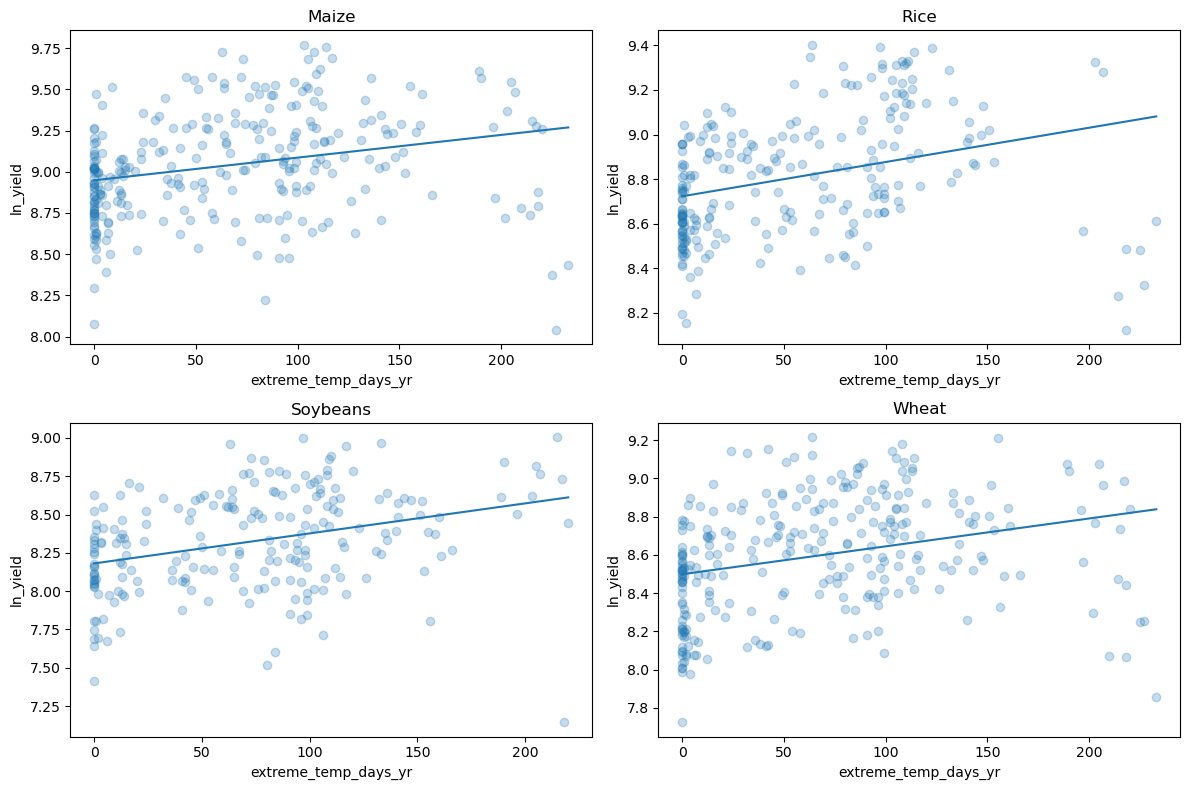

In [20]:
# descriptive plot of extreme_temp_days_yr against ln crop yield

x = "extreme_temp_days_yr"
y = "ln_yield"

crops = sorted(df_rq1_analysis["crop_name"].unique())  # should be 4

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, crop in zip(axes, crops):
    d = df_rq1_analysis[df_rq1_analysis["crop_name"] == crop][[x, y]].dropna()

    ax.scatter(d[x], d[y], alpha=0.25)

    # optional trend line (keep if you like it)
    m, b = np.polyfit(d[x], d[y], 1)
    xs = np.linspace(d[x].min(), d[x].max(), 100)
    ax.plot(xs, m * xs + b)

    ax.set_title(crop)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.tight_layout()
plt.show()

In [21]:
# checking whether slope is driven by the variable or country-level differences

crop = "Maize"  # changing crop allows us to see raw & FE slope per crop
d = df_rq1_analysis[df_rq1_analysis["crop_name"] == crop].dropna(
    subset=["ln_yield", "extreme_temp_days_yr", "iso3_code", "year"]
)

m_raw = smf.ols("ln_yield ~ extreme_temp_days_yr", data=d).fit()
m_fe = smf.ols("ln_yield ~ extreme_temp_days_yr + C(iso3_code) + C(year)", data=d).fit()

print("RAW slope:", m_raw.params["extreme_temp_days_yr"])
print("FE slope: ", m_fe.params["extreme_temp_days_yr"])

RAW slope: 0.0013761342141793845
FE slope:  -0.0018320497822461419


The only crop for which the raw & FE slope match = Rice.

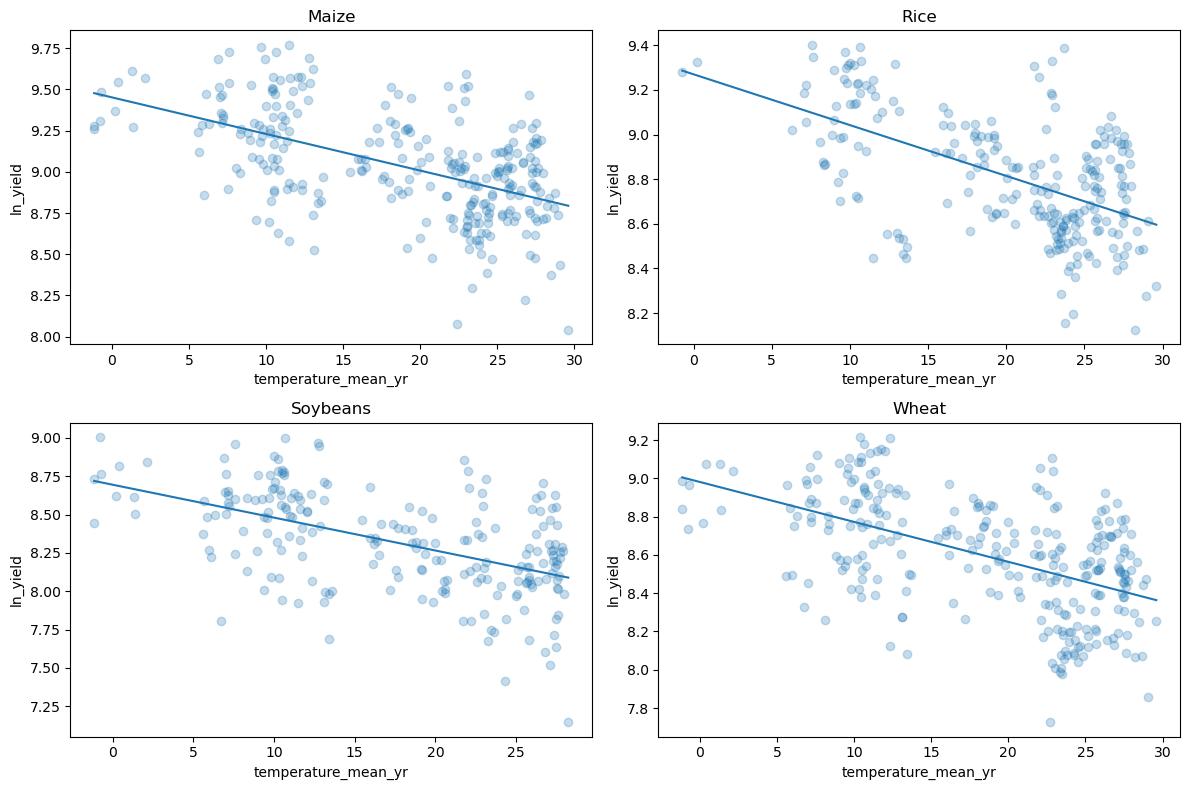

In [22]:
# descriptive plot of temperature_mean_yr against ln crop yield

x = "temperature_mean_yr"
y = "ln_yield"

crops = sorted(df_rq1_analysis["crop_name"].unique())  # should be 4

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, crop in zip(axes, crops):
    d = df_rq1_analysis[df_rq1_analysis["crop_name"] == crop][[x, y]].dropna()

    ax.scatter(d[x], d[y], alpha=0.25)

    # optional trend line (keep if you like it)
    m, b = np.polyfit(d[x], d[y], 1)
    xs = np.linspace(d[x].min(), d[x].max(), 100)
    ax.plot(xs, m * xs + b)

    ax.set_title(crop)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.tight_layout()
plt.show()

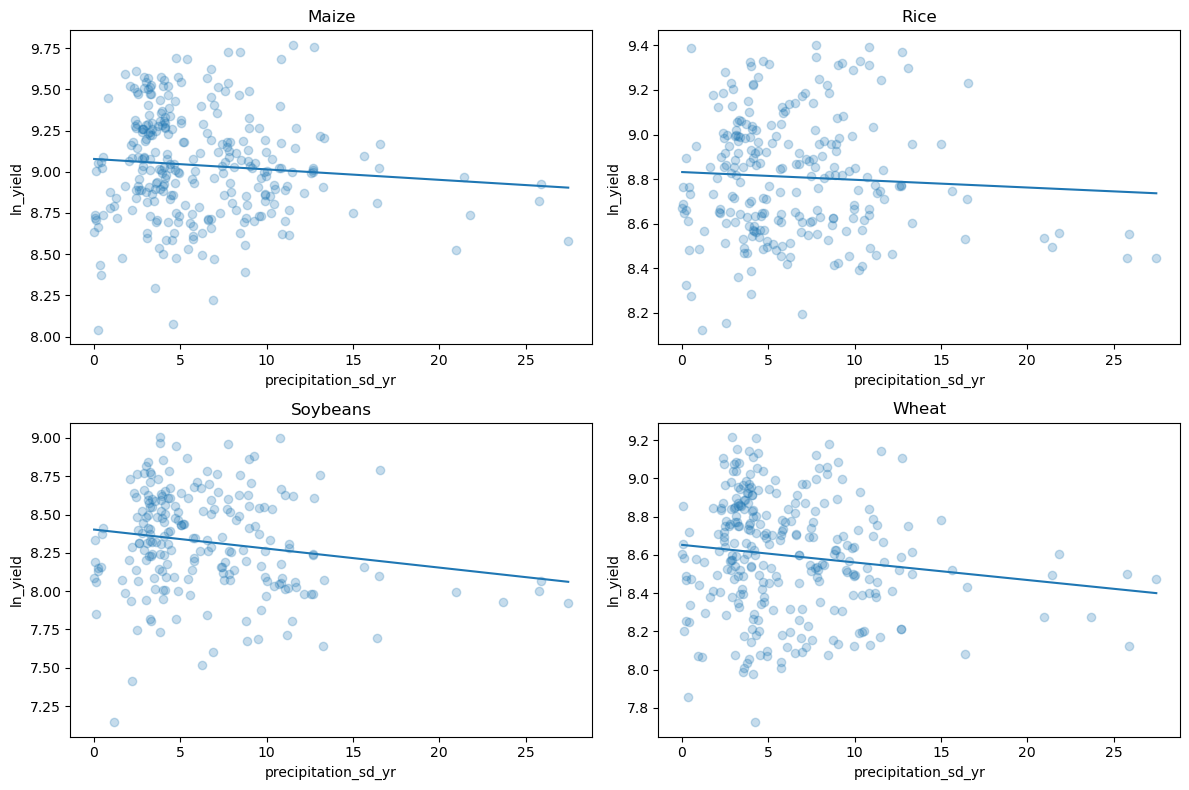

In [23]:
# descriptive plot of precipitation_sd_yr against ln crop yield

x = "precipitation_sd_yr"
y = "ln_yield"

crops = sorted(df_rq1_analysis["crop_name"].unique())  # should be 4

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, crop in zip(axes, crops):
    d = df_rq1_analysis[df_rq1_analysis["crop_name"] == crop][[x, y]].dropna()

    ax.scatter(d[x], d[y], alpha=0.25)

    # optional trend line (keep if you like it)
    m, b = np.polyfit(d[x], d[y], 1)
    xs = np.linspace(d[x].min(), d[x].max(), 100)
    ax.plot(xs, m * xs + b)

    ax.set_title(crop)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.tight_layout()
plt.show()

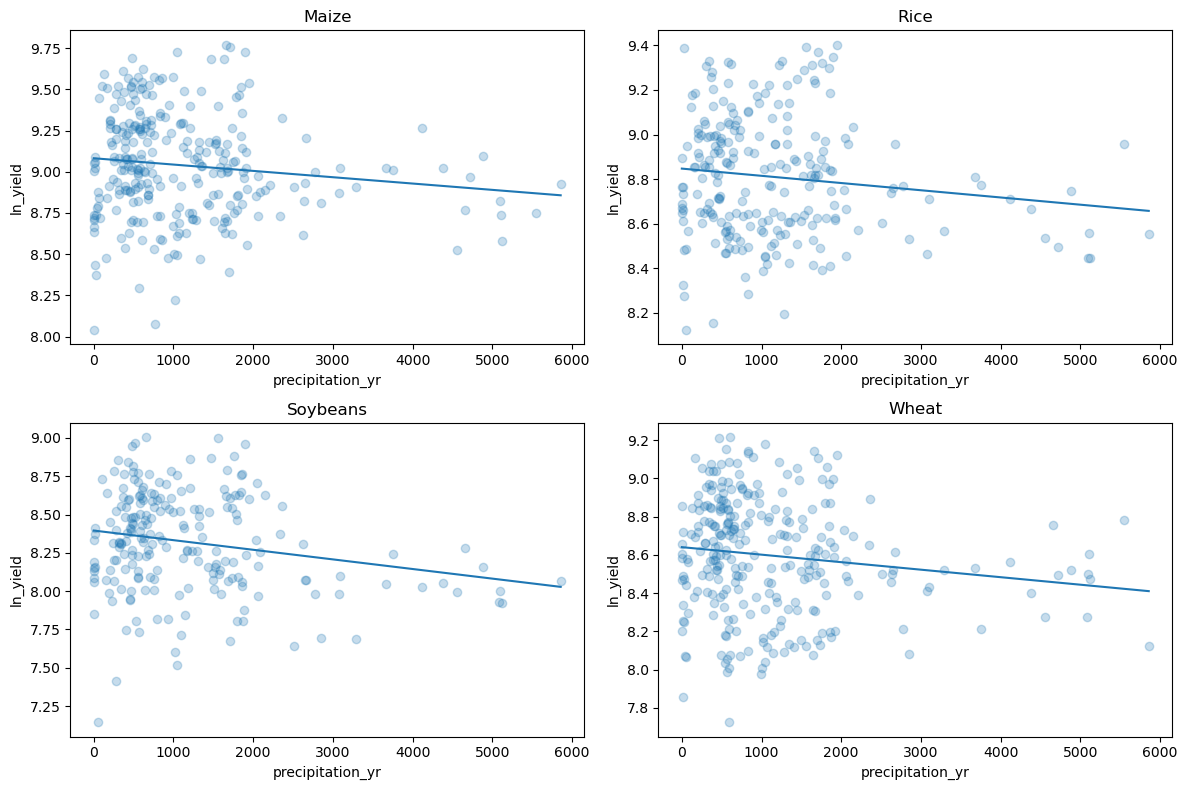

In [24]:
# descriptive plot of precipitation_yr against ln crop yield

x = "precipitation_yr"
y = "ln_yield"

crops = sorted(df_rq1_analysis["crop_name"].unique())  # should be 4

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, crop in zip(axes, crops):
    d = df_rq1_analysis[df_rq1_analysis["crop_name"] == crop][[x, y]].dropna()

    ax.scatter(d[x], d[y], alpha=0.25)

    # optional trend line (keep if you like it)
    m, b = np.polyfit(d[x], d[y], 1)
    xs = np.linspace(d[x].min(), d[x].max(), 100)
    ax.plot(xs, m * xs + b)

    ax.set_title(crop)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.tight_layout()
plt.show()

These pooled plots are descriptive and combine cross-country differences; our regression results rely on within-country variation after controlling for country and year fixed effects, which yields a different and less positive-looking relationship between extreme heat days and yields.

### Estimating the main model

We estimate crop-specific panel regressions of log yield on climate measures, controlling for irrigation and fertilizer use and including country and year fixed effects. We use cluster-robust standard errors.

In [25]:
# checking for multicollinearity between variables to make sure to not include variables that are highly correlated

clim_controls = [
    "temperature_mean_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
    "extreme_temp_days_yr",
    "fertilizer_use_kg_ha",
    "irrigation_pct",
]


def twoway_demean(df, cols, fe1="iso3_code", fe2="year"):
    out = df[cols].astype(float).copy()
    out = out - df.groupby(fe1)[cols].transform("mean")
    out = out - df.groupby(fe2)[cols].transform("mean")
    return out


def vif_table(df, crop):
    d = (
        df[df["crop_name"] == crop]
        .dropna(subset=clim_controls + ["iso3_code", "year"])
        .copy()
    )
    X = twoway_demean(d, clim_controls)
    X = X.dropna()
    X = X.loc[:, X.std() > 0]
    X = X.assign(const=1.0)

    rows = []
    for i, col in enumerate(X.columns):
        if col == "const":
            continue
        rows.append(
            {
                "crop": crop,
                "variable": col,
                "VIF": variance_inflation_factor(X.values, X.columns.get_loc(col)),
            }
        )
    return pd.DataFrame(rows).sort_values("VIF", ascending=False)


vif_table(df_rq1_analysis, "Rice").head(
    10
)  # can change crop results here to see different VIF results

,crop,variable,VIF
1,Rice,precipitation_yr,3.068357
2,Rice,precipitation_sd_yr,3.026356
0,Rice,temperature_mean_yr,1.070557
3,Rice,extreme_temp_days_yr,1.030150
4,Rice,fertilizer_use_kg_ha,1.021180
5,Rice,irrigation_pct,1.014200


In [26]:
# running a regression per crop
# dependent variable: ln_yield
# key predictors: climate + controls
# country & year FEs included to control for time-invariant country specifics + global shocks/trends
# cluster-robust SEs to deal with heteroskedasticity & serial correlation

formula = """
ln_yield
  ~ temperature_mean_yr
  + precipitation_yr
  + precipitation_sd_yr
  + extreme_temp_days_yr
  + fertilizer_use_kg_ha
  + irrigation_pct
  + C(iso3_code)
  + C(year)
"""


def run_crop_reg(df, crop):
    d = df[df["crop_name"] == crop].copy()
    model = smf.ols(formula, data=d).fit(
        cov_type="cluster", cov_kwds={"groups": d["iso3_code"]}  # cluster-robust SEs
    )
    return model, len(d)


crops = sorted(df_rq1_analysis["crop_name"].unique())
results = []

for c in crops:
    m, n = run_crop_reg(df_rq1_analysis, c)
    for var in [
        "temperature_mean_yr",
        "precipitation_yr",
        "precipitation_sd_yr",
        "extreme_temp_days_yr",
    ]:
        results.append(
            {
                "crop": c,
                "n": n,
                "variable": var,
                "coef": m.params.get(var),
                "se_robust": m.bse.get(var),
                "pvalue": m.pvalues.get(var),
                "r2": m.rsquared,
            }
        )

# extracting for each crop regression only the coefficient results for the climate variables we care about
rq1_coef_table = pd.DataFrame(results)
rq1_coef_table

,crop,n,variable,coef,se_robust,pvalue,r2
0,Maize,282,temperature_mean_yr,0.007968,0.026454,0.763251,0.680864
1,Maize,282,precipitation_yr,-0.000096,0.000070,0.173226,0.680864
2,Maize,282,precipitation_sd_yr,0.011173,0.012694,0.378762,0.680864
3,Maize,282,extreme_temp_days_yr,-0.001873,0.000998,0.060709,0.680864
4,Rice,238,temperature_mean_yr,-0.013951,0.011501,0.225102,0.874090
5,Rice,238,precipitation_yr,0.000026,0.000030,0.389391,0.874090
6,Rice,238,precipitation_sd_yr,-0.004158,0.006810,0.541476,0.874090
7,Rice,238,extreme_temp_days_yr,0.001248,0.000556,0.024867,0.874090
8,Soybeans,215,temperature_mean_yr,-0.017349,0.021692,0.423840,0.769176
9,Soybeans,215,precipitation_yr,0.000105,0.000090,0.241876,0.769176


In [27]:
# for each climate variable, list crops ordered by statistical significance (lowest p-value first)

rq1_coef_table.sort_values(["variable", "pvalue"]).groupby("variable").head(4)

,crop,n,variable,coef,se_robust,pvalue,r2
7,Rice,238,extreme_temp_days_yr,0.001248,0.000556,0.024867,0.874090
3,Maize,282,extreme_temp_days_yr,-0.001873,0.000998,0.060709,0.680864
11,Soybeans,215,extreme_temp_days_yr,-0.001732,0.001129,0.124821,0.769176
15,Wheat,282,extreme_temp_days_yr,-0.000933,0.000702,0.183893,0.757912
10,Soybeans,215,precipitation_sd_yr,-0.015936,0.013164,0.226066,0.769176
14,Wheat,282,precipitation_sd_yr,-0.010321,0.010378,0.319937,0.757912
2,Maize,282,precipitation_sd_yr,0.011173,0.012694,0.378762,0.680864
6,Rice,238,precipitation_sd_yr,-0.004158,0.006810,0.541476,0.874090
1,Maize,282,precipitation_yr,-0.000096,0.000070,0.173226,0.680864
9,Soybeans,215,precipitation_yr,0.000105,0.000090,0.241876,0.769176


In [28]:
# checking panel composition

def panel_coverage(df, crop):
    d = df[df["crop_name"] == crop].copy()
    needed = [
        "ln_yield",
        "temperature_mean_yr",
        "precipitation_yr",
        "precipitation_sd_yr",
        "extreme_temp_days_yr",
        "fertilizer_use_kg_ha",
        "irrigation_pct",
        "iso3_code",
        "year",
    ]
    d = d.dropna(subset=needed)

    counts = d.groupby("iso3_code")["year"].nunique()
    return {
        "crop": crop,
        "countries": counts.size,
        "median_years_per_country": counts.median(),
        "min_years_per_country": counts.min(),
        "share_1yr_countries": (counts == 1).mean(),
    }


pd.DataFrame(
    [
        panel_coverage(df_rq1_analysis, c)
        for c in sorted(df_rq1_analysis["crop_name"].unique())
    ]
)

,crop,countries,median_years_per_country,min_years_per_country,share_1yr_countries
0,Maize,34,8.5,6,0.000000
1,Rice,34,8.0,2,0.000000
2,Soybeans,31,8.0,1,0.129032
3,Wheat,34,8.0,6,0.000000


Soybean panel composition is quite thin compared to the other countries.

In [29]:
# robustness check for soybeans

needed = [
    "ln_yield",
    "temperature_mean_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
    "extreme_temp_days_yr",
    "fertilizer_use_kg_ha",
    "irrigation_pct",
    "iso3_code",
    "year",
]

# d0: all soybean rows that have complete data for the model variables
d0 = df_rq1_analysis[df_rq1_analysis["crop_name"] == "Soybeans"].copy()
d0 = d0.dropna(subset=needed)

before_c = d0["iso3_code"].nunique()
before_n = len(d0)

counts = d0.groupby("iso3_code")["year"].nunique()
d2 = d0[
    d0["iso3_code"].isin(counts[counts >= 2].index)
]  # d2: dropping the one-year countries

after_c = d2["iso3_code"].nunique()
after_n = len(d2)

print("Countries:", before_c, "→", after_c)
print("Rows:", before_n, "→", after_n)
print("Dropped countries:", list(counts[counts < 2].index))

Countries: 31 → 27
Rows: 215 → 211
Dropped countries: ['MLI', 'MWI', 'TZA', 'ZAF']


In [30]:
# baseline (unbalanced allowed, just drop NA)
m_soy_base = smf.ols(formula, data=d0).fit(
    cov_type="cluster", cov_kwds={"groups": d0["iso3_code"]}
)

# robustness (remove countries with only 1 year)
m_soy_drop1 = smf.ols(formula, data=d2).fit(
    cov_type="cluster", cov_kwds={"groups": d2["iso3_code"]}
)

print(
    "BASE extreme days coef:",
    m_soy_base.params["extreme_temp_days_yr"],
    "SE:",
    m_soy_base.bse["extreme_temp_days_yr"],
)
print(
    "DROP1 extreme days coef:",
    m_soy_drop1.params["extreme_temp_days_yr"],
    "SE:",
    m_soy_drop1.bse["extreme_temp_days_yr"],
)

BASE extreme days coef: -0.0017322398721115794 SE: 0.0011286077313709929
DROP1 extreme days coef: -0.0017322398721112255 SE: 0.001120781026503621


Our panel is unbalanced, which is typical in cross-country data, and fixed-effects estimation does not require a balanced panel. We checked panel coverage by crop and found that maize, rice, and wheat have no one-year countries in the regression sample, but that soybeans does include a small number of countries observed only once. Dropping those one-year soybean countries (31→27 countries; 215→211 observations) leaves the estimates for extreme heat days essentially unchanged, suggesting results are not driven by this imbalance.

## Regression analysis:

We estimated crop-specific panel regressions of log yield (kg/ha) on annual climate conditions: mean temperature, total precipitation, precipitation variability (annual SD), and extreme heat exposure (extreme temperature days). We included country and year fixed effects and used cluster-robust standard errors.

In the crop-by-crop results, the strongest statistical signal appears for extreme heat days albeit with opposite signs; rice is significant at 5% (p≈0.02), while maize is marginally significant (p≈0.06). Specifically, one additional extreme heat day is associated with roughly a +0.12% change in rice yield and a −0.19% change in maize yield (conditional on FE and controls). Given these estimates, maize appears most vulnerable to extreme heat exposure (negative coefficient), while evidence of vulnerability to mean temperature and precipitation variability is weak/imprecise in this sample.

In general, coefficient signs should be interpreted with caution given the small crop set and coarse annual aggregations. Soybeans is also slightly more unbalanced than other crops due to a few countries observed only once. Excluding those single-year countries leaves the extreme heat coefficient virtually unchanged, suggesting results are not driven by sparse panels.

### Clean graph output to describe regression analysis

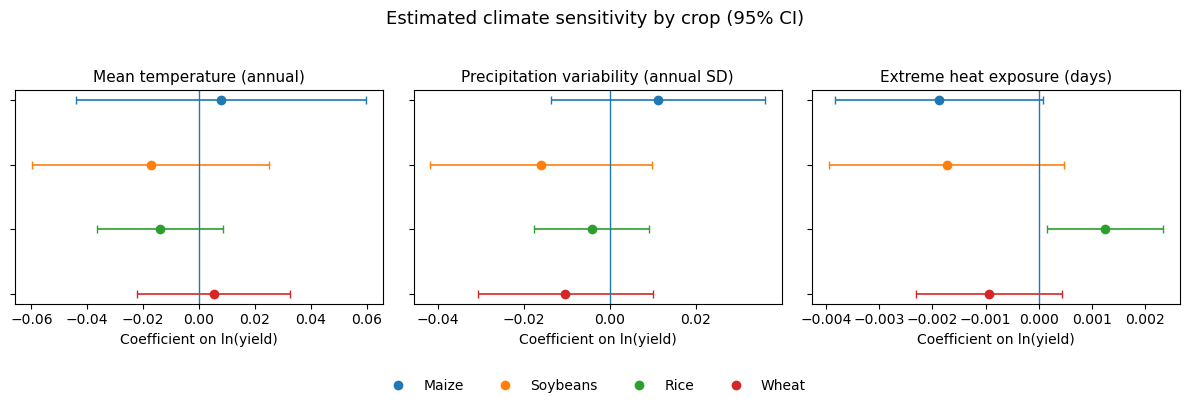

In [31]:
# 3 panel of coefficients & CIs of climate variability

# inputs
vars_3 = ["temperature_mean_yr", "precipitation_sd_yr", "extreme_temp_days_yr"]

# crop order
crop_order = ["Maize", "Soybeans", "Rice", "Wheat"]

# subset
df3 = rq1_coef_table[rq1_coef_table["variable"].isin(vars_3)].copy()

# 95% CI
df3["ci_low"] = df3["coef"] - 1.96 * df3["se_robust"]
df3["ci_high"] = df3["coef"] + 1.96 * df3["se_robust"]

# making crop an ordered categorical so sorting is consistent
df3["crop"] = pd.Categorical(df3["crop"], categories=crop_order, ordered=True)

# pretty titles
pretty = {
    "temperature_mean_yr": "Mean temperature (annual)",
    "precipitation_sd_yr": "Precipitation variability (annual SD)",
    "extreme_temp_days_yr": "Extreme heat exposure (days)",
}

# crop colors 
crop_colors = {
    "Maize": "#1f77b4",
    "Soybeans": "#ff7f0e",
    "Rice": "#2ca02c",
    "Wheat": "#d62728",
}

# --- plotting ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, v in zip(axes, vars_3):
    sub = df3[df3["variable"] == v].sort_values("crop").reset_index(drop=True)

    # y positions (top to bottom)
    y = np.arange(len(sub))
    ax.set_yticks(y)

    # plotting one point at a time so each has its own color
    for i, row in sub.iterrows():
        crop_name = str(row["crop"])
        c = crop_colors[crop_name]

        ax.errorbar(
            x=row["coef"],
            y=i,
            xerr=[[row["coef"] - row["ci_low"]], [row["ci_high"] - row["coef"]]],
            fmt="o",
            capsize=3,
            linewidth=1.2,
            color=c, # marker color
            ecolor=c, # CI color
            markersize=6,
        )

    ax.axvline(0, linewidth=1)  # zero line
    ax.set_title(pretty.get(v, v), fontsize=11)
    ax.set_xlabel("Coefficient on ln(yield)")

    # showing crop labels on left-most axis only
    if ax is axes[0]:
        ax.set_yticklabels(sub["crop"].astype(str).tolist())
    else:
        ax.set_yticklabels([])

# inverting y so first crop is at top
axes[0].invert_yaxis()

# legend (one for whole figure)
handles = [
    mlines.Line2D(
        [], [], color=crop_colors[c], marker="o", linestyle="None",
        markersize=6, label=c
    )
    for c in crop_order
]
fig.legend(handles=handles, loc="lower center", ncol=len(crop_order), frameon=False)

plt.suptitle("Estimated climate sensitivity by crop (95% CI)", fontsize=13)

# saving for report & presentation
plt.tight_layout(rect=[0, 0.10, 1, 0.95])  # leave room for legend + title
plt.savefig("fig_rq1_forest_3panel.png", dpi=300, bbox_inches="tight")
plt.show()

## Vulnerability assessment and index construction

Because climate stressors are measured on different scales (e.g., extreme-heat days vs. temperature variability in °C), raw regression coefficients are not directly comparable. We therefore convert each estimated coefficient into a typical-shock effect: the predicted change in ln(yield) from a one–standard deviation increase in the corresponding stressor, where the standard deviation is computed from that crop’s observed data. This yields a common, data-driven metric of “yield impact of a typical fluctuation.”

Our vulnerability index focuses on the following risk variables related to temperature and precipitation / water availability:

1. More extreme days → more heat stress
2. More temp variability → more instability
3. More precip variability → more erratic rainfall
4. Lower total precipitation → drier conditions / less water availability

For each crop and stressor, we compute the standardized effect (coefficient × 1 SD) and count only harmful contributions: if the standardized effect is negative (higher risk lowers yield), it contributes to vulnerability; if positive, it does not. We then aggregate harmful contributions across stressors to obtain an overall vulnerability score, optionally weighting each contribution more heavily when statistical evidence is stronger (smaller p-values).

In [32]:
# ====================================
# Vulnerability Index (Temp + Water)
# ====================================

# choosing risk variables
risk_vars = [
    "extreme_temp_days_yr",  # heat extremes
    "temperature_mean_yr",  # temperature variability
    "precipitation_sd_yr",  # precipitation variability
    "precipitation_yr",  # water availability
]

# computing the SD of each risk variable within each crop sample
sd_by_crop = (
    df_rq1_analysis.groupby("crop_name")[risk_vars]
    .std()
    .rename(columns=lambda c: f"sd_{c}")
    .reset_index()
)

# keeping only the regression results for the risk variables
coef_sub = rq1_coef_table[rq1_coef_table["variable"].isin(risk_vars)].copy()

# merging SDs onto coefficient table
coef_sub = coef_sub.merge(sd_by_crop, left_on="crop", right_on="crop_name", how="left")

# computing standardised effect: coef * SD(X) = change in ln(yield) for a 1 SD increase in X
coef_sub["std_effect"] = coef_sub["coef"] * coef_sub.apply(
    lambda r: r[f"sd_{r['variable']}"], axis=1
)

# vulnerability contribution: counting only harmful effects (negative std_effect)
coef_sub["vuln_component"] = np.maximum(0, -coef_sub["std_effect"])

# evidence weighting: higher weight attributed if p-value smaller
coef_sub["evidence_weight"] = np.log(1 / coef_sub["pvalue"].clip(lower=1e-6))

# weighted component
coef_sub["vuln_component_w"] = coef_sub["vuln_component"] * coef_sub["evidence_weight"]

# inspecting components
coef_sub_out = coef_sub[
    [
        "crop",
        "variable",
        "coef",
        "pvalue",
        "std_effect",
        "vuln_component",
        "evidence_weight",
        "vuln_component_w",
    ]
].sort_values(["crop", "variable"])

coef_sub_out

,crop,variable,coef,pvalue,std_effect,vuln_component,evidence_weight,vuln_component_w
3,Maize,extreme_temp_days_yr,-0.001873,0.060709,-0.113665,0.113665,2.801669,0.318452
2,Maize,precipitation_sd_yr,0.011173,0.378762,0.048641,0.000000,0.970848,0.000000
1,Maize,precipitation_yr,-0.000096,0.173226,-0.100844,0.100844,1.753160,0.176795
0,Maize,temperature_mean_yr,0.007968,0.763251,0.061276,0.000000,0.270168,0.000000
7,Rice,extreme_temp_days_yr,0.001248,0.024867,0.069202,0.000000,3.694232,0.000000
6,Rice,precipitation_sd_yr,-0.004158,0.541476,-0.018785,0.018785,0.613457,0.011524
5,Rice,precipitation_yr,0.000026,0.389391,0.028195,0.000000,0.943171,0.000000
4,Rice,temperature_mean_yr,-0.013951,0.225102,-0.092696,0.092696,1.491203,0.138228
11,Soybeans,extreme_temp_days_yr,-0.001732,0.124821,-0.095661,0.095661,2.080871,0.199059
10,Soybeans,precipitation_sd_yr,-0.015936,0.226066,-0.072313,0.072313,1.486927,0.107524


In [33]:
# summing vulnerability across risk channels to get one score per crop

vuln_rank = (
    coef_sub.groupby("crop", as_index=False)
    .agg(
        vuln_score=("vuln_component_w", "sum"),
        vuln_score_unweighted=("vuln_component", "sum"),
    )
    .sort_values("vuln_score", ascending=False)
)

vuln_rank

,crop,vuln_score,vuln_score_unweighted
0,Maize,0.495247,0.214509
2,Soybeans,0.425872,0.306941
1,Rice,0.149752,0.111481
3,Wheat,0.146668,0.101485


Using our combined temperature-and-water vulnerability index, maize ranks as the most climate-vulnerable crop, followed by soybeans, wheat, and rice (least vulnerable), based on evidence-weighted yield penalties from typical (1 SD) increases in climate stressors. The weighted score emphasizes relationships supported by stronger statistical evidence, while the unweighted score reflects the magnitude of estimated yield losses.

In [34]:
# looking at main drivers of vulnerability for each crop
drivers = (
    coef_sub[coef_sub["vuln_component_w"] > 0]
    .sort_values(["crop", "vuln_component_w"], ascending=[True, False])
    .groupby("crop")
    .head(2)[["crop", "variable", "coef", "pvalue", "std_effect", "vuln_component_w"]]
)
drivers

,crop,variable,coef,pvalue,std_effect,vuln_component_w
3,Maize,extreme_temp_days_yr,-0.001873,0.060709,-0.113665,0.318452
1,Maize,precipitation_yr,-0.000096,0.173226,-0.100844,0.176795
4,Rice,temperature_mean_yr,-0.013951,0.225102,-0.092696,0.138228
6,Rice,precipitation_sd_yr,-0.004158,0.541476,-0.018785,0.011524
11,Soybeans,extreme_temp_days_yr,-0.001732,0.124821,-0.095661,0.199059
8,Soybeans,temperature_mean_yr,-0.017349,0.423840,-0.138966,0.119289
15,Wheat,extreme_temp_days_yr,-0.000933,0.183893,-0.056004,0.094836
14,Wheat,precipitation_sd_yr,-0.010321,0.319937,-0.045481,0.051831


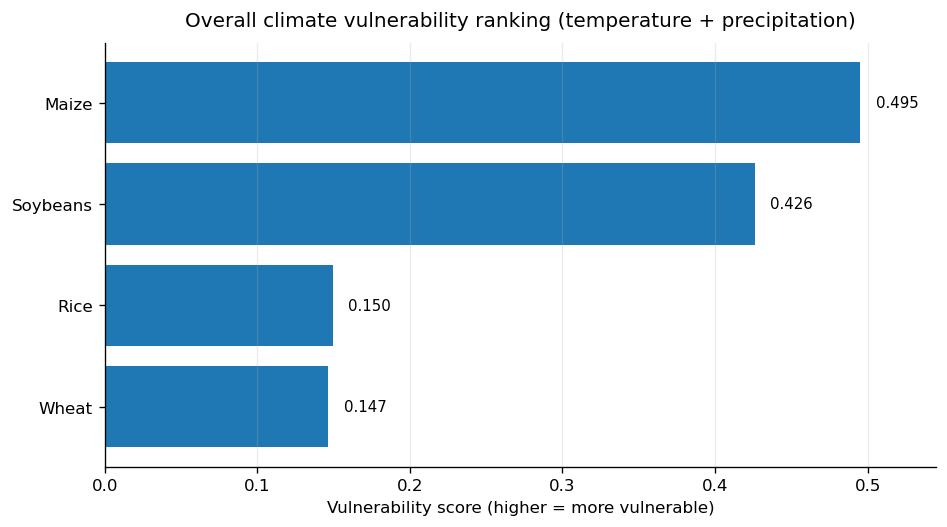

In [35]:
# Vulnerability ranking figure

plot_df = vuln_rank.sort_values("vuln_score", ascending=True).copy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

bars = ax.barh(plot_df["crop"], plot_df["vuln_score"])

# Labels + title
ax.set_xlabel("Vulnerability score (higher = more vulnerable)")
ax.set_ylabel("")
ax.set_title(
    "Overall climate vulnerability ranking (temperature + precipitation)", pad=10
)

# Subtle grid + clean spines
ax.grid(axis="x", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add value labels at end of bars
xmax = plot_df["vuln_score"].max()
ax.set_xlim(0, xmax * 1.10)  # little breathing room for labels
for bar in bars:
    w = bar.get_width()
    ax.text(
        w + xmax * 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{w:.3f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

fig.savefig("fig_vulnerability_ranking.png", dpi=300, bbox_inches="tight")

## Assessing vulnerability across income levels

We re-estimated crop-specific regressions separately for high-income versus non-high-income countries and compared climate coefficients across groups.

In [36]:
# High-income = "High income" vs. everything else (Low/Middle-income = everything else)

df_rq1_analysis["hi_income"] = (
    df_rq1_analysis["income_group"] == "High income"
).astype(int)

In [37]:
# running per-crop regression twice (HI vs non-HI)


def run_crop_reg(df, crop):
    d = df[df["crop_name"] == crop].copy()
    model = smf.ols(formula, data=d).fit(
        cov_type="cluster", cov_kwds={"groups": d["iso3_code"]}
    )
    return model, len(d)


groups = {
    "High income": df_rq1_analysis[df_rq1_analysis["hi_income"] == 1],
    "Non-high income": df_rq1_analysis[df_rq1_analysis["hi_income"] == 0],
}

In [38]:
# climate variables to compare across income groups
climate_vars = [
    "temperature_mean_yr",
    "extreme_temp_days_yr",
    "precipitation_yr",
    "precipitation_sd_yr",
]

results = []

for gname, gdf in groups.items():
    crops = sorted(gdf["crop_name"].unique())
    for c in crops:
        m, n = run_crop_reg(gdf, c)

        for var in climate_vars:
            results.append(
                {
                    "group": gname,
                    "crop": c,
                    "n": n,
                    "variable": var,
                    "coef": m.params.get(var, np.nan),
                    "se_robust": m.bse.get(var, np.nan),
                    "pvalue": m.pvalues.get(var, np.nan),
                    "r2": m.rsquared,
                }
            )

rq1_income_coef = pd.DataFrame(results)
rq1_income_coef

,group,crop,n,variable,coef,se_robust,pvalue,r2
0,High income,Maize,66,temperature_mean_yr,0.067019,0.023365,0.004126,0.295680
1,High income,Maize,66,extreme_temp_days_yr,-0.002374,0.001046,0.023300,0.295680
2,High income,Maize,66,precipitation_yr,-0.000020,0.000282,0.943151,0.295680
3,High income,Maize,66,precipitation_sd_yr,-0.004649,0.027744,0.866931,0.295680
4,High income,Rice,41,temperature_mean_yr,0.017349,0.055570,0.754881,0.582955
5,High income,Rice,41,extreme_temp_days_yr,-0.000371,0.003298,0.910524,0.582955
6,High income,Rice,41,precipitation_yr,-0.000013,0.000105,0.898965,0.582955
7,High income,Rice,41,precipitation_sd_yr,0.006222,0.013536,0.645776,0.582955
8,High income,Soybeans,68,temperature_mean_yr,-0.071471,0.041159,0.082481,0.413373
9,High income,Soybeans,68,extreme_temp_days_yr,-0.004430,0.002997,0.139350,0.413373


Estimates by income group are less precise due to smaller samples; results are suggestive.

In [39]:
# within high-income countries, which crop is most negatively affected by variables?

most_negative = (
    rq1_income_coef.sort_values(["group", "variable", "coef"])  # most negative first
    .groupby(["group", "variable"])
    .head(1)[["group", "variable", "crop", "coef", "pvalue", "n"]]
)

most_negative

,group,variable,crop,coef,pvalue,n
9,High income,extreme_temp_days_yr,Soybeans,-0.004430,0.139350,68
3,High income,precipitation_sd_yr,Maize,-0.004649,0.866931,66
10,High income,precipitation_yr,Soybeans,-0.000307,0.172340,68
8,High income,temperature_mean_yr,Soybeans,-0.071471,0.082481,68
17,Non-high income,extreme_temp_days_yr,Maize,-0.001627,0.192347,216
27,Non-high income,precipitation_sd_yr,Soybeans,-0.024763,0.137106,147
18,Non-high income,precipitation_yr,Maize,-0.000125,0.086333,216
16,Non-high income,temperature_mean_yr,Maize,-0.024375,0.414889,216


In [40]:
# comparing extreme heat (low income vs. high income)

extreme_compare = rq1_income_coef[
    rq1_income_coef["variable"] == "extreme_temp_days_yr"
].pivot_table(
    index=["crop"], columns="group", values=["coef", "pvalue"], aggfunc="first"
)

extreme_compare

coef                      pvalue                
group    High income Non-high income High income Non-high income
crop                                                            
Maize      -0.002374       -0.001627    0.023300        0.192347
Rice       -0.000371        0.001794    0.910524        0.004431
Soybeans   -0.004430       -0.000771    0.139350        0.488966
Wheat      -0.001734       -0.001131    0.317817        0.164769

By crop, rice stands out: extreme heat is estimated to increase yields in both income groups, but only the non-high-income estimate is statistically significant (p≈0.001). Maize shows a small negative extreme-heat association in both groups (slightly more negative in non-high-income), while soybeans and wheat also show negative coefficients in both groups, with no strong evidence of a clear high- vs. non-high-income split.

In [41]:
# high vs. low income (side by side) results

wide = rq1_income_coef.pivot_table(
    index=["crop", "variable"], columns="group", values="coef", aggfunc="first"
).reset_index()

# adjust the column names here if your group labels differ slightly
wide["diff_HI_minus_nonHI"] = wide["High income"] - wide["Non-high income"]
wide.sort_values(["variable", "diff_HI_minus_nonHI"])

group,crop,variable,High income,Non-high income,diff_HI_minus_nonHI
8,Soybeans,extreme_temp_days_yr,-0.004430,-0.000771,-0.003659
4,Rice,extreme_temp_days_yr,-0.000371,0.001794,-0.002165
0,Maize,extreme_temp_days_yr,-0.002374,-0.001627,-0.000747
12,Wheat,extreme_temp_days_yr,-0.001734,-0.001131,-0.000604
1,Maize,precipitation_sd_yr,-0.004649,0.015914,-0.020563
5,Rice,precipitation_sd_yr,0.006222,-0.011551,0.017773
9,Soybeans,precipitation_sd_yr,0.011832,-0.024763,0.036595
13,Wheat,precipitation_sd_yr,0.027238,-0.011805,0.039043
10,Soybeans,precipitation_yr,-0.000307,0.000156,-0.000464
14,Wheat,precipitation_yr,-0.000239,0.000080,-0.000318


Broadly, the estimated climate sensitivities differ more across income groups for mean temperature and precipitation variability than for extreme heat days, with some crops showing opposite signs across groups. Given the smaller subgroup samples, these patterns should be interpreted as suggestive.

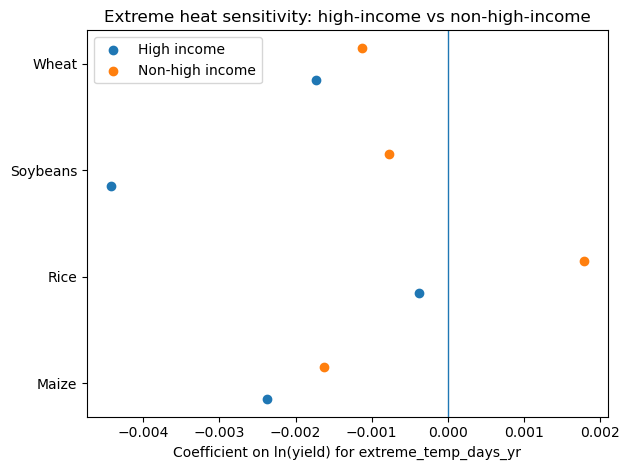

<Figure size 640x480 with 0 Axes>

In [42]:
# Figure 3: income comparison for extreme heat
ec = extreme_compare.copy()

# pulling out the two coefficient series
hi = ec[("coef", "High income")]
nonhi = ec[("coef", "Non-high income")]

crops = ec.index.astype(str)
y = np.arange(len(crops))
offset = 0.15

plt.figure()
plt.scatter(hi.values, y - offset, label="High income")
plt.scatter(nonhi.values, y + offset, label="Non-high income")
plt.axvline(0, linewidth=1)

plt.yticks(y, crops)
plt.xlabel("Coefficient on ln(yield) for extreme_temp_days_yr")
plt.title("Extreme heat sensitivity: high-income vs non-high-income")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("fig_income_diff_extreme_heat.png", dpi=300, bbox_inches="tight")

## Research Question 2 (RQ2) - Mapping Regional Food Security Risks

#### Category A: Climate Exposure Indicator

In [43]:
# creating RQ2 dataset
df_rq2 = df_integrated.copy()

# creating model data (no NAs)
df_rq2_model = df_rq1.dropna(subset=["yield_kg_ha"]).copy()
df_rq2_model.shape

(1080, 24)

In [44]:
# Indicator 1) Heat Extremes Index (country-specific min–max scaling)
# For each country, scale extreme_temp_days_yr to [0,1] based on that country's historical min and max.
# 0 = least extreme year for that country; 1 = most extreme year for that country.

# Compute country-specific min and max of extreme heat days across all years
country_min = df_rq2.groupby("country_id")["extreme_temp_days_yr"].transform("min")
country_max = df_rq2.groupby("country_id")["extreme_temp_days_yr"].transform("max")

# Avoid division-by-zero when a country has no variation (i.e. max == min)
denom = (country_max - country_min).replace(0, np.nan)

# Min–max scale within each country
df_rq2["heat_extremes_idx"] = (df_rq2["extreme_temp_days_yr"] - country_min) / denom

# If denom was 0 (no variation), set the index to 0
df_rq2["heat_extremes_idx"] = df_rq2["heat_extremes_idx"].fillna(0.0)

In [45]:
# Evaluate output
heat_table = heat_table_country1_year = (
    df_rq2.loc[df_rq2["country_id"] == 1]
    .groupby("year", as_index=False)
    .agg(
        extreme_temp_days_yr=("extreme_temp_days_yr", "mean"),
        heat_extremes_idx=("heat_extremes_idx", "mean"),
    )
)

heat_table

,year,extreme_temp_days_yr,heat_extremes_idx
0,2015,141.0,0.428571
1,2016,135.0,0.142857
2,2017,153.0,1.000000
3,2018,140.0,0.380952
4,2019,143.0,0.523810
5,2020,144.0,0.571429
6,2021,147.0,0.714286
7,2022,132.0,0.000000
8,2023,148.0,0.761905


In [46]:
# Indicator 2) Mean Temperature Stress Index
# For each country, compute the historical mean and standard deviation of annual mean temperature.
# Compute a z-score for each year: how unusual that year's temperature is relative to the country's historical distribution.
# Take the absolute value so that both unusually hot and unusually cold years count as "stress".
# Rescale to [0,1] so it can be aggregated with other exposure indices.

# Step 1: Compute country-specific historical mean and standard deviation
country_temp_mean = df_rq2.groupby("country_id")["temperature_mean_yr"].transform(
    "mean"
)
country_temp_sd = df_rq2.groupby("country_id")["temperature_mean_yr"].transform("std")

# Step 2: Compute z-score
z_score = (df_rq2["temperature_mean_yr"] - country_temp_mean) / country_temp_sd

# Step 3: Convert to absolute deviation
df_rq2["temp_z_abs"] = z_score.abs()

# Step 4: Handle cases where standard deviation was zero
df_rq2["temp_z_abs"] = (
    df_rq2["temp_z_abs"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
)

# Step 5: Rescale absolute z-scores to [0,1] for index aggregation
z_min = df_rq2["temp_z_abs"].min()
z_max = df_rq2["temp_z_abs"].max()
z_denom = z_max - z_min

if z_denom == 0:
    df_rq2["mean_temp_stress_idx"] = 0.0
else:
    df_rq2["mean_temp_stress_idx"] = (df_rq2["temp_z_abs"] - z_min) / z_denom

In [47]:
# Indicator 3) Precipitation Stress Index (variability-focused)

prec_sd_min = df_rq2["precipitation_sd_yr"].min()
prec_sd_max = df_rq2["precipitation_sd_yr"].max()
prec_sd_denom = prec_sd_max - prec_sd_min

if prec_sd_denom == 0:
    df_rq2["precip_stress_idx"] = 0.0
else:
    df_rq2["precip_stress_idx"] = (
        df_rq2["precipitation_sd_yr"] - prec_sd_min
    ) / prec_sd_denom

df_rq2["precip_stress_idx"] = df_rq2["precip_stress_idx"].clip(0, 1)

In [48]:
# Indicator 4) Moisture Deficit Index
# Compute moisture deficit as max(0, evapotranspiration_yr - precipitation_yr).
# 0 = no deficit (P >= ET); 1 = highest observed deficit.

# Compute deficit (ensure it never goes below 0)
df_rq2["moisture_deficit"] = (
    df_rq2["evapotranspiration_yr"] - df_rq2["precipitation_yr"]
).clip(lower=0)

md_min = df_rq2["moisture_deficit"].min()
md_max = df_rq2["moisture_deficit"].max()
md_denom = md_max - md_min

if md_denom == 0:
    df_rq2["moisture_deficit_idx"] = 0.0
else:
    df_rq2["moisture_deficit_idx"] = (df_rq2["moisture_deficit"] - md_min) / md_denom

df_rq2["moisture_deficit_idx"] = df_rq2["moisture_deficit_idx"].clip(0, 1)

In [49]:
# Aggregated Exposure Index
# individual crop index scores weighted by share of harvested area, country-year level
# linear time-weighting so higher scores for more recent years are weighted higher

exposure_components = [
    "heat_extremes_idx",
    "mean_temp_stress_idx",
    "precip_stress_idx",
    "moisture_deficit_idx",
]

# Row-level exposure (country-year-crop)
df_rq2["exposure_idx"] = df_rq2[exposure_components].mean(axis=1).clip(0, 1)

# Compute total harvested area in each country-year
df_rq2["total_area_country_year"] = df_rq2.groupby(["country_id", "year"])[
    "area_harvested_ha"
].transform("sum")

# Area weights (within country-year)
df_rq2["area_weight"] = df_rq2["area_harvested_ha"] / df_rq2["total_area_country_year"]

# Weighted crop contribution
df_rq2["exposure_weighted_component"] = df_rq2["exposure_idx"] * df_rq2["area_weight"]

# Aggregate to country-year exposure
country_year_exposure = df_rq2.groupby(
    ["country_id", "country_name", "year"], as_index=False
).agg(exposure_idx=("exposure_weighted_component", "sum"))

# Time-weighted country score (linearly increasing weights over available years)
country_year_exposure = country_year_exposure.sort_values(["country_id", "year"]).copy()

# Weight = 1,2,...,n_years within each country
country_year_exposure["time_weight_raw"] = (
    country_year_exposure.groupby("country_id").cumcount() + 1
)

# Normalize weights to sum to 1 within each country
country_year_exposure["time_weight"] = country_year_exposure[
    "time_weight_raw"
] / country_year_exposure.groupby("country_id")["time_weight_raw"].transform("sum")

# Apply time weights
country_year_exposure["exposure_weighted_time"] = (
    country_year_exposure["exposure_idx"] * country_year_exposure["time_weight"]
)

# 7) Final country-level exposure index (one row per country)
country_exposure = country_year_exposure.groupby(
    ["country_id", "country_name"], as_index=False
).agg(exposure_idx=("exposure_weighted_time", "sum"))

#### Category 2: Crop Sensitivity Indicator

In [50]:
import statsmodels.api as sm

In [51]:
# Crop Sensitivity Index via Panel Regression (absolute responsiveness)
# For each country–crop panel, regress yield sensitivity to climate exposure over time.

# Regression specification (estimated separately for each country–crop pair):
#   log(yield_kg_ha_{c,k,t}) = α_{c,k} + β_{c,k} · exposure_idx_{c,t} + ε_{c,k,t}
# - α_{c,k} is a country–crop–specific intercept (implicit by estimating within each panel)
# - β_{c,k} measures the responsiveness of yields to climate exposure

# Crop sensitivity defined as |β_{c,k}|, capturing the magnitude of yield response regardless of direction. This sensitivity is treated as time-invariant within each country–crop pair and later aggregated across crops using harvested-area weights.


# Drop rows with N/A
df_sens = df_rq2.dropna(subset=["yield_kg_ha", "exposure_idx"]).copy()

# Log-transform yield for elasticity interpretation
df_sens["log_yield"] = np.log(df_sens["yield_kg_ha"])

# Keep only country–crop panels with min 6 years
min_years = 6

valid_panels = (
    df_sens.groupby(["country_id", "crop_id"])["year"]
    .nunique()
    .reset_index(name="n_years")
    .query("n_years >= @min_years")
)

df_sens = df_sens.merge(
    valid_panels[["country_id", "crop_id"]], on=["country_id", "crop_id"], how="inner"
)

# Run regressions by country–crop
results = []

for (country_id, crop_id), g in df_sens.groupby(["country_id", "crop_id"]):

    X = sm.add_constant(g["exposure_idx"])
    y = g["log_yield"]

    model = sm.OLS(y, X).fit()

    beta = model.params["exposure_idx"]

    results.append(
        {
            "country_id": country_id,
            "crop_id": crop_id,
            "crop_sensitivity_beta": beta,
            "crop_sensitivity": abs(beta),
            "n_obs": int(model.nobs),
            "r_squared": model.rsquared,
        }
    )

# Create sensitivity table
crop_sensitivity = pd.DataFrame(results)

# Optional: inspect distribution
crop_sensitivity["crop_sensitivity"].head()

0    1.338436
1    0.550541
2    1.742956
3    0.684159
4    0.258924
Name: crop_sensitivity, dtype: float64

In [52]:
# Normalize crop_sensitivity to 0–1

s_min = crop_sensitivity["crop_sensitivity"].min()
s_max = crop_sensitivity["crop_sensitivity"].max()
s_denom = s_max - s_min

if s_denom == 0:
    crop_sensitivity["crop_sensitivity_idx"] = 0.0
else:
    crop_sensitivity["crop_sensitivity_idx"] = (
        (crop_sensitivity["crop_sensitivity"] - s_min) / s_denom
    ).clip(0, 1)


# Merge crop sensitivity back to df_rq2 (country-year-crop level)

df_rq2 = df_rq2.merge(
    crop_sensitivity[["country_id", "crop_id", "crop_sensitivity_idx"]],
    on=["country_id", "crop_id"],
    how="left",
)


# Area-weight across crops to get country–year sensitivity
# For each country-year, weight crop sensitivity by harvested area share, then sum to get one score per country-year.

# Total harvested area per country-year
df_rq2["total_area_country_year"] = df_rq2.groupby(["country_id", "year"])[
    "area_harvested_ha"
].transform("sum")

# Crop weights (area share within each country-year)
df_rq2["area_weight"] = df_rq2["area_harvested_ha"] / df_rq2["total_area_country_year"]

# Weighted contribution at the crop-row level
df_rq2["sensitivity_weighted_component"] = (
    df_rq2["crop_sensitivity_idx"] * df_rq2["area_weight"]
)

# Aggregate to country-year sensitivity index
country_year_sensitivity = df_rq2.groupby(
    ["country_id", "country_name", "year"], as_index=False
).agg(sensitivity_idx=("sensitivity_weighted_component", "sum"))

In [53]:
# Average sensitivity by country across all years
country_avg_sensitivity = country_year_sensitivity.groupby(
    ["country_id", "country_name"], as_index=False
).agg(sensitivity_idx=("sensitivity_idx", "mean"))

# Top 10 most sensitive countries (average over time)
country_avg_sensitivity.sort_values("sensitivity_idx", ascending=False).head(10)

,country_id,country_name,sensitivity_idx
19,20,Turkey,0.726227
15,16,Mali,0.562264
0,1,China,0.537171
2,3,South Korea,0.490495
16,17,Egypt,0.461316
21,22,Tanzania,0.423252
14,15,Malawi,0.405750
11,12,Russia,0.381315
29,30,Indonesia,0.348604
8,9,Ethiopia,0.303789


#### Category 3: Adaptability Indicator

In [54]:
# Indicator 1) Irrigation coverage index (0-1 scale)
# Interpretation: 0 = lowest irrigation coverage observed in your data; 1 = highest.

# Min–max normalize irrigation_pct across the dataset
irr_min = df_rq2["irrigation_pct"].min()
irr_max = df_rq2["irrigation_pct"].max()
irr_denom = irr_max - irr_min

if irr_denom == 0:
    # If irrigation_pct is constant everywhere, there's no variation to score
    df_rq2["irrigation_idx"] = 0.0
else:
    df_rq2["irrigation_idx"] = ((df_rq2["irrigation_pct"] - irr_min) / irr_denom).clip(
        0, 1
    )

In [55]:
# Indicator 2) Income group 4-tier capacity map
# Convert categorical income_group into a tiered adaptive capacity score.

income_map = {
    "Low income": 0.00,
    "Lower middle income": 0.33,
    "Upper middle income": 0.67,
    "High income": 1.00,
}

df_rq2["income_idx"] = df_rq2["income_group"].map(income_map)

In [56]:
# Indicator 3) Fertilizer adaptive capacity: low-input constraint

fert_col = "fertilizer_use_kg_ha"

# 1) Compute global percentile thresholds
p10 = df_rq2[fert_col].quantile(0.10)
p20 = df_rq2[fert_col].quantile(0.20)

# 2) Create tiered fertilizer adaptive capacity index
df_rq2["fertilizer_idx"] = np.select(
    [
        df_rq2[fert_col] < p10,
        (df_rq2[fert_col] >= p10) & (df_rq2[fert_col] < p20),
        df_rq2[fert_col] >= p20,
    ],
    [
        0.0,  # severely low-input
        0.5,  # moderately low-input
        1.0,  # adequate fertilizer access
    ],
)

In [57]:
# Aggregate Adaptive Capacity (Adaptability) Index
# Combines the following weighted indicators:
#   - irrigation_idx (weight 50%)
#   - income_idx     (weight 25%)
#   - fertilizer_idx (weight 25%)
# Interpretation: Higher = more adaptive capacity (less vulnerable).

# Row-level weighted adaptive capacity (country–year–crop)
df_rq2["adaptive_capacity_row"] = (
    0.50 * df_rq2["irrigation_idx"]
    + 0.25 * df_rq2["income_idx"]
    + 0.25 * df_rq2["fertilizer_idx"]
).clip(0, 1)

# Weight crops by total harvested area to get country–year adaptive capacity
df_rq2["total_area_country_year"] = df_rq2.groupby(["country_id", "year"])[
    "area_harvested_ha"
].transform("sum")

# Crop weights (area share within each country-year)
df_rq2["area_weight"] = df_rq2["area_harvested_ha"] / df_rq2["total_area_country_year"]

# Weighted contribution at crop-row level
df_rq2["adaptive_capacity_weighted_component"] = (
    df_rq2["adaptive_capacity_row"] * df_rq2["area_weight"]
)

# Aggregate to one score per country-year
country_year_adaptive_capacity = df_rq2.groupby(
    ["country_id", "country_name", "year"], as_index=False
).agg(adaptive_capacity_idx=("adaptive_capacity_weighted_component", "sum"))

# Reverse the score so higher = worse off (adaptive vulnerability)
country_year_adaptive_capacity["adaptive_vulnerability_idx"] = (
    1 - country_year_adaptive_capacity["adaptive_capacity_idx"]
).clip(0, 1)

#### Create aggregate Food & Climate Vulnerability Index (FCVI) / score

In [58]:
# Country–year FCVI (higher = worse)
country_year_fcvi = country_year_exposure.merge(
    country_year_sensitivity, on=["country_id", "country_name", "year"], how="inner"
).merge(
    country_year_adaptive_capacity,
    on=["country_id", "country_name", "year"],
    how="inner",
)

# Aggregate FCVI
country_year_fcvi["fcvi_idx"] = (
    country_year_fcvi["exposure_idx"]
    + country_year_fcvi["sensitivity_idx"]
    + country_year_fcvi["adaptive_vulnerability_idx"]
) / 3

In [59]:
# group by country
country_avg_fcvi = country_year_fcvi.groupby(
    ["country_id", "country_name"], as_index=False
).agg(fcvi_idx=("fcvi_idx", "mean"))

In [60]:
# Create country table with all indices
country_fcvi_summary = country_year_fcvi.groupby(
    ["country_id", "country_name"], as_index=False
).agg(
    exposure_idx=("exposure_idx", "mean"),
    sensitivity_idx=("sensitivity_idx", "mean"),
    adaptive_vulnerability_idx=("adaptive_vulnerability_idx", "mean"),
    fcvi_idx=("fcvi_idx", "mean"),
)

In [61]:
# Table for FCVI highest scores (most vulnerable)
top_10_highest_fcvi = country_fcvi_summary.sort_values(
    "fcvi_idx", ascending=False
).head(10)

top_10_highest_fcvi = (
    country_fcvi_summary.sort_values("fcvi_idx", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

table_output = (
    top_10_highest_fcvi.style.format(
        {
            "fcvi_idx": "{:.3f}",
        }
    )
    .background_gradient(subset=["fcvi_idx"], cmap="Reds")
    .set_caption("Top 10 Countries by Food–Climate Vulnerability Index (FCVI)")
)

table_output

table_output.to_html("fcvi_top10.html")

In [62]:
# Table for FCVI lowest scores (least vulnerable)
top_10_lowest_fcvi = country_fcvi_summary.sort_values("fcvi_idx", ascending=True).head(
    10
)

top_10_lowest_fcvi = (
    country_fcvi_summary.sort_values("fcvi_idx", ascending=True)
    .head(10)
    .reset_index(drop=True)
)

table_output = (
    top_10_lowest_fcvi.style.format(
        {
            "fcvi_idx": "{:.3f}",
        }
    )
    .background_gradient(subset=["fcvi_idx"], cmap="Reds")
    .set_caption("Countries with Lowest Food–Climate Vulnerability Index (FCVI)")
)

table_output

table_output.to_html("fcvi_bottom10.html")

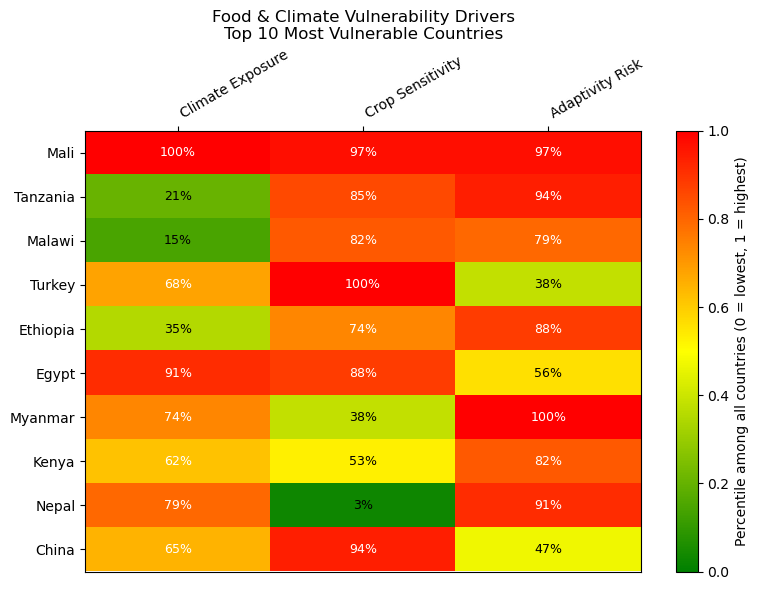

In [63]:
# Heatmap of TOP 10 most vulnerable countries (by FCVI), based on each value's PERCENTILE among ALL countries
from matplotlib.colors import LinearSegmentedColormap

# Components to show
cols = ["exposure_idx", "sensitivity_idx", "adaptive_vulnerability_idx"]
col_labels = ["Climate Exposure", "Crop Sensitivity", "Adaptivity Risk"]

# 1) Compute percentiles across ALL countries (for each column separately)
# Percentile definition here: fraction of countries with value <= this value (0..1)
all_vals = country_fcvi_summary[["country_name"] + cols].copy()

percentile_df = all_vals[cols].apply(lambda s: s.rank(pct=True, method="average"))

# Keep country names alongside percentiles
percentile_df["country_name"] = all_vals["country_name"].values

# 2) Select TOP 10 countries by raw FCVI (still your ranking basis)
top10_names = (
    country_fcvi_summary.sort_values("fcvi_idx", ascending=False)
    .head(10)["country_name"]
    .tolist()
)

# 3) Build the heatmap table: percentiles for those top 10 countries
df_heat_pct = (
    percentile_df[percentile_df["country_name"].isin(top10_names)]
    .set_index("country_name")[cols]
    .loc[top10_names]  # preserve the same ordering as top10 list
)

# 4) Custom red → green colormap (green=low percentile, red=high percentile)
red_green_cmap = LinearSegmentedColormap.from_list(
    "red_green", ["green", "yellow", "red"]
)

# 5) Plot heatmap (percentiles are already 0..1)
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(df_heat_pct.values, aspect="auto", cmap=red_green_cmap, vmin=0, vmax=1)

# Y-axis: countries
ax.set_yticks(np.arange(len(df_heat_pct.index)))
ax.set_yticklabels(df_heat_pct.index)

# X-axis: drivers
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(col_labels, rotation=30, ha="left")
ax.tick_params(axis="x", top=True, bottom=False, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position("top")

# Colorbar (now clearly percentiles)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Percentile among all countries (0 = lowest, 1 = highest)")

# Title
ax.set_title(
    "Food & Climate Vulnerability Drivers\nTop 10 Most Vulnerable Countries",
    fontsize=12,
)

# 6) Annotate cells
# Show percentiles as percentages for readability (e.g., 0.93 -> 93rd pct)
for i in range(df_heat_pct.shape[0]):
    for j in range(df_heat_pct.shape[1]):
        p = df_heat_pct.iloc[i, j]
        ax.text(
            j,
            i,
            f"{p:.0%}",
            ha="center",
            va="center",
            color="white" if p > 0.6 else "black",
            fontsize=9,
        )

plt.tight_layout()
plt.savefig("rq2_fcvi_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [64]:
# Create FCVI map table
country_fcvi_map = (
    country_year_fcvi.merge(
        df_integrated[["country_id", "iso3_code"]], on="country_id", how="left"
    )  # add back iso3_code column
    .groupby(["iso3_code", "country_name"], as_index=False)
    .agg(fcvi_idx=("fcvi_idx", "mean"))
)

# percentile rank
country_fcvi_map["fcvi_pct"] = country_fcvi_map["fcvi_idx"].rank(
    pct=True, method="average"
)

In [65]:
import plotly.express as px

# Plot index scores on global map (choropleth)
fig = px.choropleth(
    country_fcvi_map,
    locations="iso3_code",
    color="fcvi_pct",
    hover_name="country_name",
    hover_data={"fcvi_idx": ":.2f", "fcvi_pct": ":.0%"},
    color_continuous_scale="RdYlGn_r",  # red = high vulnerability
    range_color=(0, 1),
    title="Food & Climate Vulnerability Index (FCVI)\nPercentile Ranking by Country",
)

fig.update_layout(
    margin=dict(l=0, r=0, t=60, b=0),
    coloraxis_colorbar=dict(
        title="Vulnerability percentile<br>(0 = lowest, 100 = highest)"
    ),
)

plt.savefig("rq2_fcvi_globalmap.png", dpi=300, bbox_inches="tight")
fig.show()

<Figure size 640x480 with 0 Axes>

## Research Question 3 (RQ3): Understanding Agricultural Resilience

In [66]:
# Inspect structure of crop_weather_integrated
query = """
DESCRIBE crop_weather_integrated;
"""
schema = pd.read_sql(query, engine)
schema

,Field,Type,Null,Key,Default,Extra
0,country_id,int,NO,,None,
1,country_name,varchar(255),NO,,None,
2,iso3_code,char(3),NO,,None,
3,region,varchar(100),NO,,None,
4,income_group,varchar(100),NO,,None,
5,year,int,NO,,None,
6,crop_id,int,NO,,None,
7,area_harvested_ha,float,YES,,None,
8,production_tonnes,float,YES,,None,
9,yield_kg_ha,float,YES,,None,


In [67]:
# Load raw data

query = """
SELECT
    country_id,
    country_name,
    iso3_code,
    region,
    income_group,
    year,
    crop_id,
    area_harvested_ha,
    yield_kg_ha,
    fertilizer_use_kg_ha,
    irrigation_pct,
    temperature_mean_yr,
    precipitation_yr,
    precipitation_sd_yr,
    extreme_temp_days_yr,
    gdd_yr
FROM crop_weather_integrated
"""

q3_raw = pd.read_sql(query, engine)

print("Rows:", q3_raw.shape[0])
print("Columns:", q3_raw.shape[1])
q3_raw.head()

Rows: 1106
Columns: 16


,country_id,country_name,iso3_code,region,income_group,year,crop_id,area_harvested_ha,yield_kg_ha,fertilizer_use_kg_ha,irrigation_pct,temperature_mean_yr,precipitation_yr,precipitation_sd_yr,extreme_temp_days_yr,gdd_yr
0,1,China,CHN,East Asia,Upper middle income,2015,1,3462170.0,6060.13,73.41,27.1,9.363562,487.899999,3.647763,141.0,1380.900003
1,1,China,CHN,East Asia,Upper middle income,2015,2,4480770.0,7985.39,136.83,24.2,9.363562,487.899999,3.647763,141.0,1380.900003
2,1,China,CHN,East Asia,Upper middle income,2015,3,4853030.0,4823.83,173.71,39.2,9.363562,487.899999,3.647763,141.0,1380.900003
3,1,China,CHN,East Asia,Upper middle income,2015,4,4066070.0,7247.14,142.03,19.6,9.363562,487.899999,3.647763,141.0,1380.900003
4,1,China,CHN,East Asia,Upper middle income,2016,1,1859830.0,8737.91,136.19,36.4,9.532514,412.800001,2.814997,135.0,1506.799999


In [68]:
# Basic info
q3_raw.info()

# Missingness check
q3_raw.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_id            1106 non-null   int64  
 1   country_name          1106 non-null   object 
 2   iso3_code             1106 non-null   object 
 3   region                1106 non-null   object 
 4   income_group          1106 non-null   object 
 5   year                  1106 non-null   int64  
 6   crop_id               1106 non-null   int64  
 7   area_harvested_ha     1106 non-null   float64
 8   yield_kg_ha           1080 non-null   float64
 9   fertilizer_use_kg_ha  1074 non-null   float64
 10  irrigation_pct        1072 non-null   float64
 11  temperature_mean_yr   1106 non-null   float64
 12  precipitation_yr      1106 non-null   float64
 13  precipitation_sd_yr   1106 non-null   float64
 14  extreme_temp_days_yr  1106 non-null   float64
 15  gdd_yr               

irrigation_pct          34
fertilizer_use_kg_ha    32
yield_kg_ha             26
country_id               0
country_name             0
iso3_code                0
region                   0
income_group             0
year                     0
crop_id                  0
area_harvested_ha        0
temperature_mean_yr      0
precipitation_yr         0
precipitation_sd_yr      0
extreme_temp_days_yr     0
gdd_yr                   0
dtype: int64

In [69]:
# Prepare data for area-weighted aggregation

# Drop rows with missing yield (required for weighting)
q3_weight = q3_raw.dropna(subset=["yield_kg_ha"]).copy()

print("Rows before drop:", q3_raw.shape[0])
print("Rows after drop:", q3_weight.shape[0])

# Create yield × area term
q3_weight["yield_area"] = q3_weight["yield_kg_ha"] * q3_weight["area_harvested_ha"]

# Sanity check
q3_weight[
    [
        "country_name",
        "year",
        "crop_id",
        "yield_kg_ha",
        "area_harvested_ha",
        "yield_area",
    ]
].head()

Rows before drop: 1106
Rows after drop: 1080


,country_name,year,crop_id,yield_kg_ha,area_harvested_ha,yield_area
0,China,2015,1,6060.13,3462170.0,2.098120e+10
1,China,2015,2,7985.39,4480770.0,3.578070e+10
2,China,2015,3,4823.83,4853030.0,2.341019e+10
3,China,2015,4,7247.14,4066070.0,2.946738e+10
4,China,2016,1,8737.91,1859830.0,1.625103e+10


In [70]:
# Aggregate to country-year level (area-weighted yield)

country_year = q3_weight.groupby(
    ["country_id", "country_name", "iso3_code", "region", "income_group", "year"],
    as_index=False,
).agg(
    total_area_ha=("area_harvested_ha", "sum"), total_yield_area=("yield_area", "sum")
)

# Compute area-weighted yield
country_year["yield_weighted_kg_ha"] = (
    country_year["total_yield_area"] / country_year["total_area_ha"]
)

print("Country-year rows:", country_year.shape[0])
country_year.head()

Country-year rows: 306


,country_id,country_name,iso3_code,region,income_group,year,total_area_ha,total_yield_area,yield_weighted_kg_ha
0,1,China,CHN,East Asia,Upper middle income,2015,16862040.0,1.096395e+11,6502.147218
1,1,China,CHN,East Asia,Upper middle income,2016,8691180.0,5.216502e+10,6002.064605
2,1,China,CHN,East Asia,Upper middle income,2017,10672280.0,7.208063e+10,6754.004741
3,1,China,CHN,East Asia,Upper middle income,2018,7219492.0,3.775803e+10,5230.012282
4,1,China,CHN,East Asia,Upper middle income,2019,8670453.0,5.509563e+10,6354.412168


In [71]:
# Check for any weird values
country_year[["total_area_ha", "yield_weighted_kg_ha"]].describe()

,total_area_ha,yield_weighted_kg_ha
count,3.060000e+02,306.000000
mean,8.004062e+06,6518.998922
std,3.465305e+06,1831.537035
min,1.086452e+06,3173.815747
25%,5.166407e+06,5096.825661
50%,8.314100e+06,6178.195628
75%,1.063126e+07,7578.181401
max,1.919226e+07,12006.260930


In [72]:
# Yield stability metrics (country-level)

yield_stability = country_year.groupby(
    ["country_id", "country_name", "iso3_code", "region", "income_group"],
    as_index=False,
).agg(
    yield_mean=("yield_weighted_kg_ha", "mean"),
    yield_sd=("yield_weighted_kg_ha", "std"),
    n_years=("year", "nunique"),
)

# Coefficient of variation
yield_stability["yield_cv"] = (
    yield_stability["yield_sd"] / yield_stability["yield_mean"]
)

yield_stability.head()

,country_id,country_name,iso3_code,region,income_group,yield_mean,yield_sd,n_years,yield_cv
0,1,China,CHN,East Asia,Upper middle income,6509.712542,648.146120,9,0.099566
1,2,Nepal,NPL,South Asia,Low income,4484.623117,408.527251,9,0.091095
2,3,South Korea,KOR,East Asia,High income,9003.022664,839.625300,9,0.093260
3,4,United States,USA,North America,High income,8493.165236,1442.212254,9,0.169809
4,5,Japan,JPN,East Asia,High income,9101.189964,1268.831109,9,0.139414


In [73]:
# Distribution of CVs
yield_stability["yield_cv"].describe()

count    34.000000
mean      0.142279
std       0.041751
min       0.056567
25%       0.108264
50%       0.138911
75%       0.173925
max       0.244091
Name: yield_cv, dtype: float64

In [74]:
# Check countries with very few years
yield_stability.sort_values("n_years").head()

,country_id,country_name,iso3_code,region,income_group,yield_mean,yield_sd,n_years,yield_cv
0,1,China,CHN,East Asia,Upper middle income,6509.712542,648.146120,9,0.099566
31,32,United Kingdom,GBR,Europe,High income,9231.065446,1540.181932,9,0.166848
30,31,Myanmar,MMR,Southeast Asia,Low income,4063.061015,558.494204,9,0.137457
29,30,Indonesia,IDN,Southeast Asia,Lower middle income,6004.906115,791.067408,9,0.131737
28,29,Kenya,KEN,Sub-Saharan Africa,Low income,5090.252968,777.216199,9,0.152687


**Note:** Agricultural resilience is proxied by low interannual variability in area-weighted yields.

In [75]:
# Climate variability metrics (country-level)

climate_variability = q3_raw.groupby(
    ["country_id", "country_name", "iso3_code", "region", "income_group"],
    as_index=False,
).agg(
    precip_sd_mean=("precipitation_sd_yr", "mean"),
    extreme_temp_mean=("extreme_temp_days_yr", "mean"),
    temp_mean_sd=("temperature_mean_yr", "std"),
    n_years=("year", "nunique"),
)

climate_variability.head()

,country_id,country_name,iso3_code,region,income_group,precip_sd_mean,extreme_temp_mean,temp_mean_sd,n_years
0,1,China,CHN,East Asia,Upper middle income,3.675351,142.555556,0.511636,9
1,2,Nepal,NPL,South Asia,Low income,21.733894,21.555556,0.669121,9
2,3,South Korea,KOR,East Asia,High income,9.638464,105.111111,0.541854,9
3,4,United States,USA,North America,High income,5.380506,120.419355,0.690817,9
4,5,Japan,JPN,East Asia,High income,9.826192,110.000000,0.465533,9


In [76]:
climate_variability[["precip_sd_mean", "extreme_temp_mean", "temp_mean_sd"]].describe()

,precip_sd_mean,extreme_temp_mean,temp_mean_sd
count,34.000000,34.000000,34.000000
mean,6.125020,65.400879,0.509101
std,4.109744,58.989763,0.238249
min,0.196471,0.000000,0.126870
25%,3.312216,8.216667,0.356508
50%,4.750166,66.888889,0.518353
75%,8.675288,102.436111,0.602883
max,21.733894,216.071429,1.296114


In [77]:
climate_variability.sort_values("extreme_temp_mean", ascending=False).head()

,country_id,country_name,iso3_code,region,income_group,precip_sd_mean,extreme_temp_mean,temp_mean_sd,n_years
15,16,Mali,MLI,Sub-Saharan Africa,Low income,0.813254,216.071429,0.446288,9
5,6,Canada,CAN,North America,High income,3.274609,204.689655,1.140350,9
11,12,Russia,RUS,Europe,Upper middle income,3.425037,152.620690,0.660341,9
0,1,China,CHN,East Asia,Upper middle income,3.675351,142.555556,0.511636,9
3,4,United States,USA,North America,High income,5.380506,120.419355,0.690817,9


In [78]:
# Merge yield stability and climate variability

resilience_df = pd.merge(
    yield_stability,
    climate_variability[
        ["country_id", "precip_sd_mean", "extreme_temp_mean", "temp_mean_sd"]
    ],
    on="country_id",
    how="inner",
)

print("Rows:", resilience_df.shape[0])
resilience_df.head()

Rows: 34


,country_id,country_name,iso3_code,region,income_group,yield_mean,yield_sd,n_years,yield_cv,precip_sd_mean,extreme_temp_mean,temp_mean_sd
0,1,China,CHN,East Asia,Upper middle income,6509.712542,648.146120,9,0.099566,3.675351,142.555556,0.511636
1,2,Nepal,NPL,South Asia,Low income,4484.623117,408.527251,9,0.091095,21.733894,21.555556,0.669121
2,3,South Korea,KOR,East Asia,High income,9003.022664,839.625300,9,0.093260,9.638464,105.111111,0.541854
3,4,United States,USA,North America,High income,8493.165236,1442.212254,9,0.169809,5.380506,120.419355,0.690817
4,5,Japan,JPN,East Asia,High income,9101.189964,1268.831109,9,0.139414,9.826192,110.000000,0.465533


In [79]:
# Sanity check: no missing values
resilience_df.isnull().sum()

country_id           0
country_name         0
iso3_code            0
region               0
income_group         0
yield_mean           0
yield_sd             0
n_years              0
yield_cv             0
precip_sd_mean       0
extreme_temp_mean    0
temp_mean_sd         0
dtype: int64

In [80]:
# Creating a simple climate variability index

# Standardize climate variables
for var in ["precip_sd_mean", "extreme_temp_mean", "temp_mean_sd"]:
    resilience_df[f"{var}_z"] = (
        resilience_df[var] - resilience_df[var].mean()
    ) / resilience_df[var].std()

# Simple climate variability index
resilience_df["climate_var_index"] = resilience_df[
    ["precip_sd_mean_z", "extreme_temp_mean_z", "temp_mean_sd_z"]
].mean(axis=1)

resilience_df[["country_name", "yield_cv", "climate_var_index"]].head()

,country_name,yield_cv,climate_var_index
0,China,0.099566,0.240836
1,Nepal,0.091095,1.242133
2,South Korea,0.093260,0.555185
3,United States,0.169809,0.504745
4,Japan,0.139414,0.491256


In [81]:
# Defining resilience quadrants

# Define median thresholds

yield_cv_median = resilience_df["yield_cv"].median()
climate_var_median = resilience_df["climate_var_index"].median()

yield_cv_median, climate_var_median

(0.13891132129727915, -0.10149376313390451)

In [82]:
# Classify countries into resilience quadrants


def classify_resilience(row):
    if (
        row["climate_var_index"] >= climate_var_median
        and row["yield_cv"] <= yield_cv_median
    ):
        return "Resilient under stress"
    elif (
        row["climate_var_index"] >= climate_var_median
        and row["yield_cv"] > yield_cv_median
    ):
        return "Vulnerable to climate stress"
    elif (
        row["climate_var_index"] < climate_var_median
        and row["yield_cv"] <= yield_cv_median
    ):
        return "Stable (low stress)"
    else:
        return "Unstable (low stress)"


resilience_df["resilience_type"] = resilience_df.apply(classify_resilience, axis=1)

resilience_df["resilience_type"].value_counts()

resilience_type
Vulnerable to climate stress    10
Stable (low stress)             10
Resilient under stress           7
Unstable (low stress)            7
Name: count, dtype: int64

In [83]:
# Inspect who is resilient

resilience_df.sort_values(["resilience_type", "yield_cv"])[
    [
        "country_name",
        "region",
        "income_group",
        "yield_cv",
        "climate_var_index",
        "resilience_type",
    ]
]

,country_name,region,income_group,yield_cv,climate_var_index,resilience_type
6,Thailand,Southeast Asia,Upper middle income,0.080287,-0.082085,Resilient under stress
1,Nepal,South Asia,Low income,0.091095,1.242133,Resilient under stress
2,South Korea,East Asia,High income,0.093260,0.555185,Resilient under stress
23,Morocco,North Africa,Lower middle income,0.093516,0.912564,Resilient under stress
0,China,East Asia,Upper middle income,0.099566,0.240836,Resilient under stress
24,Pakistan,South Asia,Lower middle income,0.109102,-0.001539,Resilient under stress
30,Myanmar,Southeast Asia,Low income,0.137457,0.041195,Resilient under stress
20,Argentina,South America,Upper middle income,0.056567,-0.617018,Stable (low stress)
21,Tanzania,Sub-Saharan Africa,Low income,0.103348,-0.606632,Stable (low stress)
16,Egypt,North Africa,Lower middle income,0.106660,-0.481166,Stable (low stress)


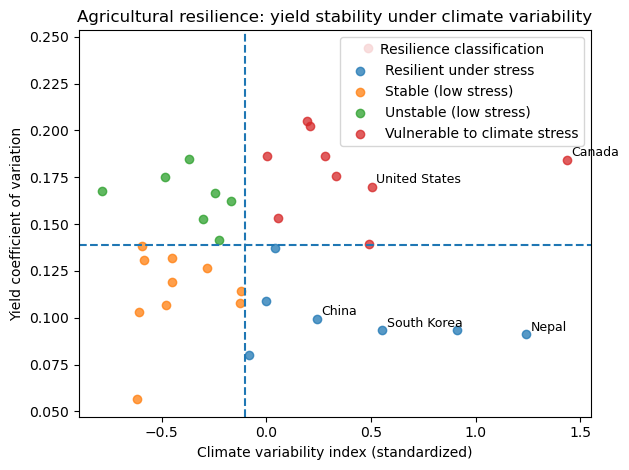

In [84]:
# Visualizing agricultural resilience

# Scatter plot
for r_type, df_sub in resilience_df.groupby("resilience_type"):
    plt.scatter(
        df_sub["climate_var_index"], df_sub["yield_cv"], label=r_type, alpha=0.75
    )

# Median lines
plt.axvline(climate_var_median, linestyle="--")
plt.axhline(yield_cv_median, linestyle="--")

# Label a few key case-study countries
key_countries = ["Nepal", "China", "United States", "Canada", "South Korea"]
for _, row in resilience_df.iterrows():
    if row["country_name"] in key_countries:
        plt.text(
            row["climate_var_index"] + 0.02,
            row["yield_cv"] + 0.002,
            row["country_name"],
            fontsize=9,
        )

plt.xlabel("Climate variability index (standardized)")
plt.ylabel("Yield coefficient of variation")
plt.title("Agricultural resilience: yield stability under climate variability")

plt.legend(title="Resilience classification")
plt.tight_layout()
plt.show()

In [85]:
# Compare characteristics by resilience type

resilience_summary = (
    q3_raw.merge(
        resilience_df[["country_id", "resilience_type"]], on="country_id", how="left"
    )
    .groupby("resilience_type")
    .agg(
        avg_irrigation=("irrigation_pct", "mean"),
        avg_fertilizer=("fertilizer_use_kg_ha", "mean"),
        avg_area=("area_harvested_ha", "mean"),
    )
)

resilience_summary

,avg_irrigation,avg_fertilizer,avg_area
resilience_type,,,
Resilient under stress,23.845714,93.822623,2.124682e+06
Stable (low stress),23.568671,85.524385,2.233499e+06
Unstable (low stress),25.709479,103.643709,2.243354e+06
Vulnerable to climate stress,31.727000,135.042800,2.443252e+06


## *Extensions*
Quantify the **"resilience premium"**
– how much does investment in irrigation or other adaptations reduce yield variability?

In [86]:
# Build a country-level “investment” dataset

# Extension 1A: Check missingness in key investment vars (raw)
q3_raw[["irrigation_pct", "fertilizer_use_kg_ha"]].isnull().sum()

irrigation_pct          34
fertilizer_use_kg_ha    32
dtype: int64

In [87]:
# Country-level averages for investment proxies

invest_country = q3_raw.groupby(["country_id"], as_index=False).agg(
    irrigation_mean=("irrigation_pct", "mean"),
    fertilizer_mean=("fertilizer_use_kg_ha", "mean"),
)

invest_country.head()

,country_id,irrigation_mean,fertilizer_mean
0,1,29.657143,127.880000
1,2,9.991429,26.552941
2,3,36.938889,180.087143
3,4,37.537931,190.869667
4,5,41.446875,185.414286


In [88]:
# Merge investment measures into resilience_df

resilience_ext = pd.merge(resilience_df, invest_country, on="country_id", how="left")

resilience_ext[
    [
        "country_name",
        "yield_cv",
        "climate_var_index",
        "irrigation_mean",
        "fertilizer_mean",
    ]
].head()

,country_name,yield_cv,climate_var_index,irrigation_mean,fertilizer_mean
0,China,0.099566,0.240836,29.657143,127.880000
1,Nepal,0.091095,1.242133,9.991429,26.552941
2,South Korea,0.093260,0.555185,36.938889,180.087143
3,United States,0.169809,0.504745,37.537931,190.869667
4,Japan,0.139414,0.491256,41.446875,185.414286


In [89]:
# Quick check: any missing after merge

resilience_ext[["irrigation_mean", "fertilizer_mean"]].isnull().sum()

irrigation_mean    0
fertilizer_mean    0
dtype: int64



#### Quantifying the “premium” with a simple regression:

*How much does investment in irrigation or other adaptations reduce yield variability?*

yield_cv = b0 + b1* irrigation + b2* fertilizer + b3* climate_var_index + controls + error

Where b1 = change in yield_cv per 1 percentage point irrigation

In [90]:
# Baseline "resilience premium" model
# Irrigation is in percentage points (0–100). Interpretation is per 10 pp.

model1 = smf.ols(
    "yield_cv ~ climate_var_index + irrigation_mean + fertilizer_mean",
    data=resilience_ext,
).fit(cov_type="HC1")

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               yield_cv   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.4245
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.737
Time:                        16:44:22   Log-Likelihood:                 60.691
No. Observations:                  34   AIC:                            -113.4
Df Residuals:                      30   BIC:                            -107.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1288      0.02

In [91]:
# Convert coefficients into a “premium” statement

b_irrig = model1.params["irrigation_mean"]
b_fert = model1.params["fertilizer_mean"]

print("Irrigation coefficient:", b_irrig)
print("Fertilizer coefficient:", b_fert)

print("\nInterpretation:")
print(
    "A +10 percentage-point increase in irrigation is associated with a change in yield_cv of:",
    10 * b_irrig,
)

print(
    "A +10 kg/ha increase in fertilizer is associated with a change in yield_cv of:",
    10 * b_fert,
)

Irrigation coefficient: 0.0010938024076263197
Fertilizer coefficient: -0.00014526263678492132

Interpretation:
A +10 percentage-point increase in irrigation is associated with a change in yield_cv of: 0.010938024076263196
A +10 kg/ha increase in fertilizer is associated with a change in yield_cv of: -0.0014526263678492132


#### The “under stress” version
Is irrigation especially valuable when climate variability is high?

*yield_cv ~ climate_var_index + irrigation + irrigation*climate_var_index + ...*


In [92]:
# interaction model (resilience premium under climate stress)

model2 = smf.ols(
    "yield_cv ~ climate_var_index * irrigation_mean + fertilizer_mean",
    data=resilience_ext,
).fit(cov_type="HC1")

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               yield_cv   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                     1.213
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.327
Time:                        16:44:22   Log-Likelihood:                 61.502
No. Observations:                  34   AIC:                            -113.0
Df Residuals:                      29   BIC:                            -105.4
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [93]:
# compute the irrigation effect at: Low climate stress (25th percentile of climate_var_index) & High climate stress (75th percentile)

q25 = resilience_ext["climate_var_index"].quantile(0.25)
q75 = resilience_ext["climate_var_index"].quantile(0.75)

b_irrig = model2.params["irrigation_mean"]
b_int = model2.params["climate_var_index:irrigation_mean"]

effect_low = b_irrig + b_int * q25
effect_high = b_irrig + b_int * q75

print("Climate index 25th pct:", q25)
print("Climate index 75th pct:", q75)

print("\nMarginal effect of irrigation (per 1 pp):")
print("Low climate stress:", effect_low)
print("High climate stress:", effect_high)

print("\nPer +10 pp irrigation (policy scale):")
print("Low climate stress:", 10 * effect_low)
print("High climate stress:", 10 * effect_high)

Climate index 25th pct: -0.43175774288489605
Climate index 75th pct: 0.2710026196637541

Marginal effect of irrigation (per 1 pp):
Low climate stress: 0.0006979373710140789
High climate stress: 0.0016250752029337175

Per +10 pp irrigation (policy scale):
Low climate stress: 0.006979373710140789
High climate stress: 0.016250752029337175


#### Identifying tipping points where resilience breaks down;

In [94]:
# Climate stress bins (tipping-point analysis)

# Create climate stress terciles
resilience_ext["climate_stress_bin"] = pd.qcut(
    resilience_ext["climate_var_index"],
    q=3,
    labels=["Low stress", "Medium stress", "High stress"],
)

resilience_ext["climate_stress_bin"].value_counts()

climate_stress_bin
High stress      12
Low stress       11
Medium stress    11
Name: count, dtype: int64

In [95]:
# Mean yield CV by climate stress bin

resilience_ext.groupby("climate_stress_bin", observed=True)["yield_cv"].agg(
    ["mean", "std", "count"]
)

,mean,std,count
climate_stress_bin,,,
Low stress,0.133391,0.037012,11
Medium stress,0.135072,0.031074,11
High stress,0.157032,0.052325,12


In [96]:
# Does irrigation still help in high stress?

# Compare irrigation vs yield CV within bins
resilience_ext.groupby("climate_stress_bin", observed=True).agg(
    mean_yield_cv=("yield_cv", "mean"), mean_irrigation=("irrigation_mean", "mean")
)

,mean_yield_cv,mean_irrigation
climate_stress_bin,,
Low stress,0.133391,19.568361
Medium stress,0.135072,30.056038
High stress,0.157032,28.631264


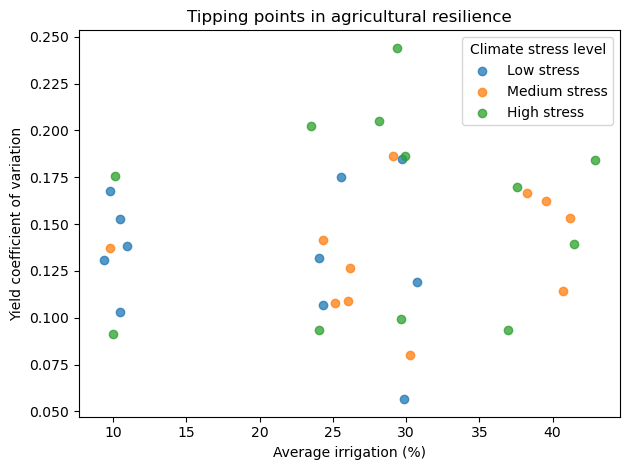

In [97]:
# Visual tipping point

for label, df_sub in resilience_ext.groupby("climate_stress_bin", observed=True):
    plt.scatter(df_sub["irrigation_mean"], df_sub["yield_cv"], label=label, alpha=0.75)


plt.xlabel("Average irrigation (%)")
plt.ylabel("Yield coefficient of variation")
plt.title("Tipping points in agricultural resilience")
plt.legend(title="Climate stress level")
plt.tight_layout()
plt.show()

## AI Use Statement

AI tools, primarily ChatGPT, were used in support of the creation of the code in this report. AI was used to troubleshoot errors, brainstorm appropriate data structures and coding solutions, and to clarify SQL & Python coding syntax. It was further used to brainstorm index and assessment ideas. All AI use complied with UBC and course guidelines. All code, output, and comments in this file have been customized and verified by the authors. 